In [ ]:
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
import time

In [ ]:
start = time.time()
pgm_path = '/content/color_checker.pgm'
bayer = io.imread(pgm_path).astype(np.uint16)

In [ ]:
# plt.imshow(bayer, cmap = 'gray')

Dead Pixel Concealment (DPC)

In [ ]:
def DPC(bayer, thresh):
  """
  inputs:
    bayer = raw bayer domain image
    thresh = threshold value

  outputs:
    dpc_img = bayer domain image with dead pixels corrected for with mean filter
  """

  padded_bayer = np.pad(bayer, (2,2), 'reflect')
  thresh = thresh * 8

  p1 = padded_bayer[:-4:1, :-4:1] # create 9 different arrays for p0:p8
  p2 = padded_bayer[:-4:1, 2:-2:1]
  p3 = padded_bayer[:-4:1, 4::1]
  p4 = padded_bayer[2:-2:1, :-4:1]
  p0 = padded_bayer[2:-2:1, 2:-2:1]
  p5 = padded_bayer[2:-2:1, 4::1]
  p6 = padded_bayer[4::1, :-4:1]
  p7 = padded_bayer[4::1, 2:-2:1]
  p8 = padded_bayer[4::1, 4::1]

  dv = (p2 + p7 + 1) // 2
  dh = (p4 + p5 + 1) // 2
  ddr = (p1 + p8 + 1) // 2
  ddl = (p3 + p6 + 1) // 2
  min_gradients = np.minimum.reduce((dv, dh, ddr, ddl))

  neighbors = np.array([p1, p2, p3, p4, p5, p6, p7, p8]) # store p1:p8 in a seperate array

  diff = np.abs(neighbors - p0) # store absolute differences between p1:p8 and p0
  condition = diff > thresh # p1:p8 that stores location of all dead pixels
  sum = np.sum(condition, axis = 0) # allows you to check only one 2d array, and test for missed dead pixels with all neighbors

  dpc_img = np.where(sum >= 1, min_gradients, bayer).astype(np.uint16) # if labelled dead by any neighbor, replace with mean

  return dpc_img

In [ ]:
module_start = time.time()
thresh = np.max(bayer) * 0.05
dpc_img = DPC(bayer, thresh)
print("time taken by this module = ", (time.time() - module_start))

# plt.imshow(dpc_img, cmap = 'gray')

time taken by this module =  3.0830602645874023


Black Level Compensation (BLC)

In [ ]:
def BLC(dpc_img, offsets):
  """
  inputs:
    dpc_img = bayer domain image after dead pixel concealment
    offsets = dictionary with black level offset values, keys (bl_r, bl_gr, bl_gb, bl_b)

  outputs:
    blc_img = bayer domain image with adjusted black levels
  """

  blc_img = np.empty(dpc_img.shape) # create an empty 2D array of the same size as the dpc_img

  r = dpc_img[::2, ::2] # use array splicing to extract r, gr, gb, and b pixels from the full bayer image
  gr = dpc_img[1::2, ::2]
  gb = dpc_img[::2, 1::2]
  b = dpc_img[1::2, 1::2]

  r = r + offsets['bl_r'] # add offsets to each channel
  gr = gr + offsets['bl_gr']
  gb = gb + offsets['bl_gb']
  b = b + offsets['bl_b']

  blc_img[::2, ::2] = r # return the adjusted values to create a final image
  blc_img[1::2, ::2] = gr
  blc_img[::2, 1::2] = gb
  blc_img[1::2, 1::2] = b

  return np.clip(blc_img, 0, None)

In [ ]:
module_start = time.time()
offsets = {'bl_r':-10, 'bl_gr':-10, 'bl_gb':-10, 'bl_b':-10}
blc_img = BLC(bayer, offsets)
print("time taken by this module = ", (time.time() - module_start))

# plt.imshow(blc_img, cmap = 'gray')

time taken by this module =  0.24988102912902832


Lens Shading Correction (LSC)

In [ ]:
def LSC(blc_img, k, offset):
  """
  inputs:
    blc_img = bayer domain image after black level compensation
    k = correction factor to control strength of the correction
    offset = offset in case the final image is too bright

  outputs:
    lsc_img = bayer domain image adjusted for lens shading
  """

  rows, cols = blc_img.shape
  center_x = (cols // 2) + 1 # identify center if the image
  center_y = (rows // 2) + 1
  x, y = np.meshgrid(np.arange(cols), np.arange(rows)) # create an array where each index is the radial distance from the center
  radial_dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
  radial_dist = np.where(radial_dist <= 1300, 1300, radial_dist) # ensure correction only applies on the outer edges

  lsc_img = (blc_img * (k * radial_dist + 1) - offset).astype(np.uint16) # apply correction

  return lsc_img

In [ ]:
module_start = time.time()
k = 0.0015
offset = 0
lsc_img = LSC(blc_img, k, offset)
print("time taken by this module = ", (time.time() - module_start))

# plt.imshow(lsc_img, cmap = 'gray')

time taken by this module =  1.646719217300415


Anti-Aliasing Noise Filter (AAf)

In [ ]:
def AAF(lsc_img, k):
  """
  inputs:
    lsc_img = bayer domain image after lens shading correcting
    k = anti-aliasing correction factor to control strenght of anti-aliasing

  outputs:
    aaf_img = bayer domain image after applying anti-aliasing
  """

  padded_img = np.pad(lsc_img, (2,2), 'reflect') # pad the image to give corner pixels full set of neighbors

  p1 = padded_img[:-4:1, :-4:1] # create 9 different arrays for p0:p8
  p2 = padded_img[:-4:1, 2:-2:1]
  p3 = padded_img[:-4:1, 4::1]
  p4 = padded_img[2:-2:1, :-4:1]
  p0 = padded_img[2:-2:1, 2:-2:1] * (k**0.5)
  p5 = padded_img[2:-2:1, 4::1]
  p6 = padded_img[4::1, :-4:1]
  p7 = padded_img[4::1, 2:-2:1]
  p8 = padded_img[4::1, 4::1]

  neighbors = np.array([p1, p2, p3, p4, p0, p5, p6, p7, p8]) / ((k + 8)**0.5)
  aaf_img = (np.sum(neighbors, axis = 0)).astype(np.uint16) # apply the filter

  return aaf_img

In [ ]:
module_start = time.time()
k = 64
aaf_img = AAF(lsc_img, k)
print("time taken by this module = ", (time.time() - module_start))

# plt.imshow(aaf_img, cmap = 'gray')

time taken by this module =  2.736480474472046


Auto White Balance Gain Control (AWB)

In [ ]:
def AWB(aaf_img):
  """
  inputs:
    aaf_img = bayer domain image after anti-aliasing noise filter

  outputs:
    awb_img = bayer domain image after auto white balance
  """

  awb_img = np.copy(aaf_img) # create a copy of the bayer image to apply auto white balance

  r = awb_img[::2, ::2] # use array splicing to extract r, gr, gb, and b pixels from the full bayer image
  gr = awb_img[::2, 1::2]
  gb = awb_img[1::2, ::2]
  b = awb_img[1::2, 1::2]

  r_ave = np.sum(r) / r.size # compute averages of r, g, and b channels
  g_ave = (np.sum(gr) + np.sum(gb)) / (gr.size + gb.size)
  b_ave = np.sum(b) / b.size

  r_gain = g_ave / r_ave # compute gains for r, g, and b channels
  g_gain = g_ave / g_ave
  b_gain = g_ave / b_ave

  awb_img[::2, ::2] = r * r_gain # apply gains to r, g, and b channels
  awb_img[::2, 1::2] = gr * g_gain
  awb_img[1::2, ::2] = gb * g_gain
  awb_img[1::2, 1::2] = b * b_gain

  return awb_img.astype(np.uint16)

In [ ]:
module_start = time.time()
awb_img = AWB(aaf_img)
print("time taken by this module = ", (time.time() - module_start))

# plt.imshow(awb_img, cmap = 'gray')

time taken by this module =  0.2723555564880371


Color Filter Array Interpolation

In [ ]:
def CFA(awb_img):
  """
  inputs:
    awb_img = bayer domain image after auto white balance gain control

  outputs:
    cfa_img = 8 bit RGB image
  """

  awb_img = awb_img.astype(np.uint32) # change dtype to allow for larger numbers during demosaicing
  max_val = np.max(awb_img)
  r = np.empty(awb_img.shape) # create empty arrays for R, G, and B channels
  g = np.empty(awb_img.shape)
  b = np.empty(awb_img.shape)
  padded_img = np.pad(awb_img, (1,1), 'reflect') # pad image to extract shifted channels

  # R-channel
  r_on_r = padded_img[1:-2:2, 1:-2:2] # red intensity values on red pixels

  r_right = padded_img[1:-2:2, 3::2] # shifted matrix of red intensity values in specified direction, same size as r_on_r
  r_down = padded_img[3::2, 1:-2:2]
  r_down_right = padded_img[3::2, 3::2]

  r_on_gr = np.right_shift((r_on_r + r_right), 1) # calculate red intensity values from green and blue pixels
  r_on_gb = np.right_shift((r_on_r + r_down), 1)
  r_on_b = np.right_shift((r_on_r + r_right + r_down + r_down_right), 2)

  r[::2, ::2] = r_on_r # map red intensity values to the entire red channel array
  r[::2, 1::2] = r_on_gr
  r[1::2, ::2] = r_on_gb
  r[1::2, 1::2] = r_on_b

  #G-channel
  g_on_gr = padded_img[1:-2:2, 2:-1:2] # green intensity values on green pixels
  g_on_gb = padded_img[2:-1:2, 1:-2:2]

  g_up = padded_img[:-3:2, 1:-2:2] # shifted matrix of green intensity values in specified direction, same size as g_on_gr
  g_right = padded_img[2:-1:2, 3::2]
  g_left = padded_img[1:-2:2, :-3:2]
  g_down = padded_img[3::2, 2:-1:2]

  g_on_r = np.right_shift((g_left + g_up + g_on_gr + g_on_gb), 2) # calculate green intensity values from red and blue pixels
  g_on_b = np.right_shift((g_right + g_down + g_on_gr + g_on_gb), 2)

  g[::2, ::2] = g_on_r # map green intensity values to the entire green channel array
  g[::2, 1::2] = g_on_gr
  g[1::2, ::2] = g_on_gb
  g[1::2, 1::2] = g_on_b

  # B-channel
  b_on_b = padded_img[2:-1:2, 2:-1:2] # blue intensity values on green pixels

  b_left = padded_img[2:-1:2, :-3:2] # shifted matrix of blue intensity values in specified direction, same size as b_on_b
  b_up = padded_img[:-3:2, 2:-1:2]
  b_up_left = padded_img[:-3:2, :-3:2]

  b_on_gr = np.right_shift((b_on_b + b_up), 1) # calculate blue intensity values from red and green pixels
  b_on_gb = np.right_shift((b_on_b + b_left), 1)
  b_on_r = np.right_shift((b_on_b + b_left + b_up + b_up_left), 2)

  b[::2, ::2] = b_on_r # map blue intensity values to the entire blue channel array
  b[::2, 1::2] = b_on_gr
  b[1::2, ::2] = b_on_gb
  b[1::2, 1::2] = b_on_b

  r = np.clip(r, 0, max_val) # ensure all values are of the correct and same dtype before stacking
  g = np.clip(g, 0, max_val)
  b = np.clip(b, 0, max_val)

  cfa_img = np.dstack((r, g, b)) # Resize and stack the channels to RGB
  cfa_img = ((cfa_img / max_val) * 255).astype(np.uint8) # rescale the image to 8 bit to skip color correction matrix

  return cfa_img

In [ ]:
module_start = time.time()
cfa_img = CFA(awb_img)
print("time taken by this module = ", (time.time() - module_start))

# plt.imshow(cfa_img)

time taken by this module =  1.7980411052703857


Gamma Correction (GAC)

In [ ]:
def GAC(cfa_img, gamma):
  """
  inputs:
    cfa_img = RGB image right after demosaicing
    gamma = correction factor

  outputs:
    gac_img = RGB imgae after gamma correction
  """

  cfa_img = cfa_img.astype(np.uint16) # change dtype to allow for larger numbers during gamma correction
  gac_img = cfa_img**(1 / gamma) # apply gamma correction
  max_val = np.max(gac_img)

  gac_img = ( (gac_img / max_val) * 255).astype(np.uint8) # resize the RGB image to 8 bit integer and skip the CCM

  return gac_img

In [ ]:
module_start = time.time()
gamma = 1.6
gac_img = GAC(cfa_img, gamma)
print("time taken by this module = ", (time.time() - module_start))

# plt.imshow(gac_img)

time taken by this module =  3.160160779953003


Color Space Conversion (CSC)

In [ ]:
def CSC(gac_img):
  """
  inputs:
    gac_img = RGB image after gamma correction

  outputs:
    y = gray scale image as y channel (luma)
    cbcr_img = chroma color information (Cb and Cr channels)
  """

  r = gac_img[:, :, 0] # seperate R, G, and B channels
  g = gac_img[:, :, 1]
  b = gac_img[:, :, 2]

  y = (0.299 * r + 0.587 * g + 0.114 * b).astype(np.uint8) # apply the convesrion formulas
  cb = (0.564 * (b - y) ).astype(np.uint8)
  cr = (0.713 * (r - y) ).astype(np.uint8)

  cbcr_img = np.dstack((cb, cr)) # stack cb and cr channels to form chroma image

  return y, cbcr_img

In [ ]:
def YCbCr_to_RGB(y, cbcr_img):
    """
    inputs:
      y = gray scale image as y channel (luma)
      cbcr_img = chroma color information (Cb and Cr channels)

    output:
      rgb_img = RGB image after conversion from YCbCr
    """

    cb = cbcr_img[:, :, 0] # seperate Cb and Cr channels
    cr = cbcr_img[:, :, 1]

    r = (y + (cr/0.713)).astype(np.uint8) # apply the convesrion formulas
    b = (y + (cb/0.564)).astype(np.uint8)
    g = ((y - 0.299*r - 0.114*b) / 0.587).astype(np.uint8)

    rgb_img = np.dstack((r, g, b)) # Stack R, G, and B channels to form the RGB image

    return rgb_img

In [ ]:
module_start = time.time()
y, cbcr_img = CSC(gac_img)

print("time taken by this module = ", (time.time() - module_start))

'''
plt.subplot(1,3,1)
plt.imshow(y, cmap = 'gray')

plt.subplot(1,3,2)
plt.imshow(cbcr_img[:, :, 0], cmap = 'gray')

plt.subplot(1,3,3)
plt.imshow(cbcr_img[:, :, 1], cmap = 'gray')
'''

time taken by this module =  0.8067350387573242


"\nplt.subplot(1,3,1)\nplt.imshow(y, cmap = 'gray')\n\nplt.subplot(1,3,2)\nplt.imshow(cbcr_img[:, :, 0], cmap = 'gray')\n\nplt.subplot(1,3,3)\nplt.imshow(cbcr_img[:, :, 1], cmap = 'gray')\n"

Noise Filter for Chroma (NFC)

In [ ]:
def NFC(cbcr_img, alpha, thresh):
  """
  inputs:
    cbcr_img = Cb and Cr channels of the YCbCr image
    alpha = controls intensity of correction for noisy pixels
    thresh = controls strictness of noisy pixel detection

  outputs:
    nfc_img = Cb and Cr channels of YCbCr image after applying noise filter on both
  """

  cbcr_img = cbcr_img.astype(np.uint16)
  nfc_img = np.copy(cbcr_img) # make a copy of the cbcr_img to apply noise filter for chroma

  for k in range(len(cbcr_img[0,0])):
    # apply the filter to both Cb and Cr
    img = cbcr_img[:, :, k]
    padded_img = np.pad(img, (1, 1), 'reflect') # apply reflect padding on the image to give edge pixels neighbors

    p1 = padded_img[:-2:1, :-2:1] # define p0 : p8 to use in filter
    p2 = padded_img[:-2:1, 1:-1:1]
    p3 = padded_img[:-2:1, 2::1]
    p4 = padded_img[1:-1:1, :-2:1]
    p0 = padded_img[1:-1:1, 1:-1:1]
    p5 = padded_img[1:-1:1, 2::1]
    p6 = padded_img[2::1, :-2:1]
    p7 = padded_img[2::1, 1:-1:1]
    p8 = padded_img[2::1, 2::1]

    neighbors = np.array([p1, p2, p3, p4, p5, p6, p7, p8]) # place all neighbor pixels into a seperate array

    mean = np.mean(neighbors, axis = 0) # calculate mean
    std = np.std(neighbors, axis = 0) # calculate standard deviation
    limit_upper = mean + (thresh * std) # calculate upper and lower limits for the values of p0 relative to neighbors
    limit_lower = mean - (thresh * std)

    editted_img = np.where((p0 > limit_upper) | (p0 < limit_lower), alpha * mean + (1 - alpha) * p0, img) # apply filter

    nfc_img[:, :, k] = editted_img # update the nfc_img

  return nfc_img.astype(np.uint8) # rescale the nfc_img

In [ ]:
module_start = time.time()
alpha = 0.3
thresh = 2.5
nfc_img = NFC(cbcr_img, alpha, thresh)

print("time taken by this module = ", (time.time() - module_start))

'''
plt.subplot(131)
plt.imshow(nfc_img[:, :, 0], cmap = 'gray')

plt.subplot(132)
plt.imshow(nfc_img[:, :, 1], cmap = 'gray')

plt.subplot(133)
rgb_img = YCbCr_to_RGB(y, nfc_img)
plt.imshow(rgb_img)
'''

time taken by this module =  8.298291444778442


"\nplt.subplot(131)\nplt.imshow(nfc_img[:, :, 0], cmap = 'gray')\n\nplt.subplot(132)\nplt.imshow(nfc_img[:, :, 1], cmap = 'gray')\n\nplt.subplot(133)\nrgb_img = YCbCr_to_RGB(y, nfc_img)\nplt.imshow(rgb_img)\n"

Hue Saturation Control (HSC)

In [ ]:
def HSC(nfc_img, delta_theta, s):
  """
  inputs:
    nfc_img = Cb and Cr channels after noise filter for chroma
    delta_theta = change in hue angle
    s = saturation correction intensity

  outputs:
    hsc_img = Cb and Cr channels after hue saturation control
  """

  nfc_img = nfc_img.astype(np.uint16) # change dtype to allow for larger numbers during hue saturation control
  hsc_img = np.copy(nfc_img) # create a copy of the image to apply correction

  nfc_cb = nfc_img[:, :, 0] + 1 # extract the cb and cr channels, and add 1 to eliminate the divide by 0 effect
  nfc_cr = nfc_img[:, :, 1] + 1

  theta = np.arctan2(nfc_cr, nfc_cb) # calculate hue angle and distances for entire image array
  dist = np.sqrt(nfc_cb**2 + nfc_cr**2)

  hsc_cb = s * dist * np.cos(theta + delta_theta) # apply conversion to both channels
  hsc_cr = s * dist * np.sin(theta + delta_theta)

  hsc_img[:, :, 0] = np.clip(hsc_cb, 0, 255).astype(np.uint8) # rescale both cb and cr channels
  hsc_img[:, :, 1] = np.clip(hsc_cr, 0, 255).astype(np.uint8)

  return hsc_img

In [ ]:
module_start = time.time()
delta_theta = 0
s = 1
hsc_img = HSC(nfc_img, delta_theta, s)

print("time taken by this module = ", (time.time() - module_start))

'''
plt.subplot(131)
plt.imshow(hsc_img[:, :, 0], cmap = 'gray')

plt.subplot(132)
plt.imshow(hsc_img[:, :, 1], cmap = 'gray')

plt.subplot(133)
rgb_img = YCbCr_to_RGB(y, hsc_img)
plt.imshow(rgb_img)
'''

time taken by this module =  1.6890850067138672


"\nplt.subplot(131)\nplt.imshow(hsc_img[:, :, 0], cmap = 'gray')\n\nplt.subplot(132)\nplt.imshow(hsc_img[:, :, 1], cmap = 'gray')\n\nplt.subplot(133)\nrgb_img = YCbCr_to_RGB(y, hsc_img)\nplt.imshow(rgb_img)\n"

Noise Filter For Luma (NFL)

In [ ]:
def NFL(y):
  """
  inputs:
    y = gray scale image as y channel (luma)

  outputs:
    nfl_y = gray scale image as y channel (luma) after median noise filter
  """

  y = y.astype(np.uint16) # change dtype to allow for larger numbers during noise filter for luma
  padded_img = np.pad(y, (1,1), 'reflect') # apply reflect padding on the image to give edge pixels neighbors

  p1 = padded_img[:-2:1, :-2:1] # define matrixes for p0 : p8 to be used in filter
  p2 = padded_img[:-2:1, 1:-1:1]
  p3 = padded_img[:-2:1, 2::1]
  p4 = padded_img[1:-1:1, :-2:1]
  p0 = padded_img[1:-1:1, 1:-1:1]
  p5 = padded_img[1:-1:1, 2::1]
  p6 = padded_img[2::1, :-2:1]
  p7 = padded_img[2::1, 1:-1:1]
  p8 = padded_img[2::1, 2::1]

  neighbors = np.array([p1, p2, p3, p4, p0, p5, p6, p7, p8]) # define array with all pixels in the 9x9 filter area

  nfl_y = np.median(neighbors, axis = 0) # apply median filter to the entire image

  return nfl_y.astype(np.uint8) # rescale the image and return

In [ ]:
module_start = time.time()
nfl_y = NFL(y)

print("time taken by this module = ", (time.time() - module_start))

'''
plt.subplot(121)
plt.imshow(nfl_y, cmap = 'gray')

plt.subplot(122)
rgb_img = YCbCr_to_RGB(nfl_y, hsc_img)
plt.imshow(rgb_img)
'''

time taken by this module =  3.106314182281494


"\nplt.subplot(121)\nplt.imshow(nfl_y, cmap = 'gray')\n\nplt.subplot(122)\nrgb_img = YCbCr_to_RGB(nfl_y, hsc_img)\nplt.imshow(rgb_img)\n"

Edge Enhancement Filters (EEF)

In [ ]:
def EEF(nfl_y, k):
  """
  inputs:
    nfl_y = y channel after noise filter for luma
    k = correction factor to control intensity of edge enhancement

  outputs:
    eef_y = y channel after edge enhancement filter
  """
  nfl_y = nfl_y.astype(np.uint32) # change dtype to allow for larger numbers during edge enhancement filter
  padded_img = np.pad(nfl_y, (1,1), 'reflect') # apply reflect padding on the image to give edge pixels neighbors

  p1 = padded_img[:-2:1, :-2:1] * (-1) # define matrixes for p0:p8 to be used in filter, and scale to create laplacian filter
  p2 = padded_img[:-2:1, 1:-1:1] * (-1)
  p3 = padded_img[:-2:1, 2::1] * (-1)
  p4 = padded_img[1:-1:1, :-2:1] * (-1)
  p0 = padded_img[1:-1:1, 1:-1:1] * (8)
  p5 = padded_img[1:-1:1, 2::1] * (-1)
  p6 = padded_img[2::1, :-2:1] * (-1)
  p7 = padded_img[2::1, 1:-1:1] * (-1)
  p8 = padded_img[2::1, 2::1] * (-1)

  neighbors = np.array([p1, p2, p3, p4, p0, p5, p6, p7, p8]) / 6 # define array with all pixels in 9x9 filter areas

  edges = np.sum(neighbors, axis = 0).astype(np.uint8) # extract edge map from lapacian
  scaled_edges = np.where(edges < 200, 0, edges) # scale edge map to only host strong edges

  eef_y = nfl_y + (k * scaled_edges) # add edge map back to original image to yield stronger edges

  return eef_y.astype(np.uint8) # rescale and return

In [ ]:
module_start = time.time()
k = 1
eef_y = EEF(nfl_y, k)

print("time taken by this module = ", (time.time() - module_start))

'''
plt.subplot(121)
plt.imshow(eef_y, cmap = 'gray')

plt.subplot(122)
rgb_img = YCbCr_to_RGB(eef_y, hsc_img)
plt.imshow(rgb_img)
'''

time taken by this module =  4.663652420043945


"\nplt.subplot(121)\nplt.imshow(eef_y, cmap = 'gray')\n\nplt.subplot(122)\nrgb_img = YCbCr_to_RGB(eef_y, hsc_img)\nplt.imshow(rgb_img)\n"

Contrast Brightness Control (CBC)

In [ ]:
def CBC(eef_y, brightness_offset, new_max, new_min):
  """
  inputs:
    eef_y = y channel after edge enhancement filter applied
    brightness_offset = brightness control offset
    new_max = desired new maximum value
    new_min = desired new minimum value

  outputs:
    cbc_y = y channel after contrast brightness control
  """
  old_max = np.max(eef_y) # save useful values for contrast calculation
  old_min = np.min(eef_y)
  old_mid = (old_max + old_min) / 2
  new_mid = (new_max + new_min) / 2

  contrast_y = ( ( (eef_y - old_mid) * (new_max - new_min) ) / (old_max - old_min) ) + new_mid # calculate contrast

  cbc_y = np.clip(contrast_y + brightness_offset, 0, 240).astype(np.uint8) # apply correction and clip

  return cbc_y

In [ ]:
module_start = time.time()
brightness_offset = 10
new_max = 240
new_min = 0
cbc_y = CBC(eef_y, brightness_offset, new_max, new_min)

print("time taken by this module = ", (time.time() - module_start))

'''
plt.subplot(121)
plt.imshow(cbc_y, cmap = 'gray')

plt.subplot(122)
rgb_img = YCbCr_to_RGB(cbc_y, hsc_img)
plt.imshow(rgb_img)
'''

time taken by this module =  0.44867467880249023


"\nplt.subplot(121)\nplt.imshow(cbc_y, cmap = 'gray')\n\nplt.subplot(122)\nrgb_img = YCbCr_to_RGB(cbc_y, hsc_img)\nplt.imshow(rgb_img)\n"

total time taken by full pipeline:  86.56613898277283


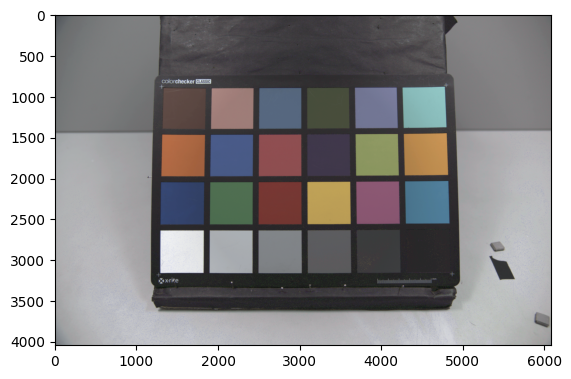

In [ ]:
print('total time taken by full pipeline: ', (time.time() - start))

rgb_img = YCbCr_to_RGB(cbc_y, hsc_img)
plt.imshow(rgb_img)

In [ ]:
'''
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Define a path to save the image within your Drive
save_path = '/content/drive/MyDrive/temp.jpg'

# Save rgb_img using OpenCV (or Pillow)
import cv2  # You can also use PIL for saving images
cv2.imwrite(save_path, rgb_img)

print(f"Image saved to: {save_path}")
'''

'\nfrom google.colab import drive\n\n# Mount your Google Drive\ndrive.mount(\'/content/drive\')\n\n# Define a path to save the image within your Drive\nsave_path = \'/content/drive/MyDrive/temp.jpg\'\n\n# Save rgb_img using OpenCV (or Pillow)\nimport cv2  # You can also use PIL for saving images\ncv2.imwrite(save_path, rgb_img)\n\nprint(f"Image saved to: {save_path}")\n'